# Wingsail Controller Prototype

In [14]:
# Install Python dependencies
!pip3 install numpy scipy matplotlib


Defaulting to user installation because normal site-packages is not writeable


In [16]:
# Imports
%matplotlib inline
import numpy as np
import scipy
import matplotlib.pyplot as plt


## Function `compute_reynolds_number` Implementation

It takes the apparent wind speed and the chord width to computes the Reynold's number. 

In [6]:
CHORD_WIDTH_MAIN_SAIL = 0.14  # meters, trim tab chord width is not included
KINEMATIC_VISCOSITY = 0.000014207  # {m^2 / s at 10degC} and air density at 1.225 {kg / m^3}


def compute_reynolds_number(apparent_wind_speed):
    reynolds_number = (apparent_wind_speed * CHORD_WIDTH_MAIN_SAIL) / KINEMATIC_VISCOSITY
    return reynolds_number


## Function `compute_angle_of_attack` Implementation

It takes the Reynolds number and uses a lookup table to find the angle of attack.

In [7]:
def compute_angle_of_attack(reynolds_number, look_up_table):
    desired_alpha = np.interp(reynolds_number, look_up_table[:, 0], look_up_table[:, 1])
    return desired_alpha


## Function `compute_trim_tab_angle` Implementation

It takes the desired alpha value and computes the resulting trim tab angle.

In [8]:
# wind_direction will use degrees unit and follow same convention of WindSensor.msg
# 0° means the apparent wind is blowing from the bow to the stern of the boat, increase CW
# Range: -180 < direction <= 180 for symmetry
def compute_trim_tab_angle(desired_alpha, wind_direction, boat_direction):
    # additional variables to be used in future more in depth calculations

    trim_tab_angle = -desired_alpha * wind_direction / abs(wind_direction)
    return trim_tab_angle


## Testing sample values:

In [9]:
apparent_wind_speed = 10  # m/s
wind_direction = 0  # degrees
boat_direction = 0  # degrees
look_up_table = np.array(
    [[50000, 5.75], [100000, 6.75], [200000, 7], [500000, 9.75], [1000000, 10]]
)  # reynolds number, angle of attack

reynolds = compute_reynolds_number(apparent_wind_speed)
alpha = compute_angle_of_attack(reynolds, look_up_table)
trim_tab_angle = compute_trim_tab_angle(alpha, wind_direction, boat_direction)

print("Reynolds number: ", reynolds)
print("Angle of attack: ", alpha)
print("Trim tab angle: ", trim_tab_angle)


Reynolds number:  98542.97177447738
Angle of attack:  6.7208594354895475
Trim tab angle:  nan


/tmp/ipykernel_55673/969836044.py:7: RuntimeWarning: invalid value encountered in scalar divide
  trim_tab_angle = -desired_alpha * wind_direction / abs(wind_direction)


## Test 2: Wind direction at 40 degrees

In [10]:
apparent_wind_speed = 100  # m/s
wind_direction = 40  # degrees
boat_direction = 0  # degrees
look_up_table = np.array(
    [[50000, 5.75], [100000, 6.75], [200000, 7], [500000, 9.75], [1000000, 10]]
)  # reynolds number, angle of attack

reynolds = compute_reynolds_number(apparent_wind_speed)
alpha = compute_angle_of_attack(reynolds, look_up_table)
trim_tab_angle = compute_trim_tab_angle(alpha, wind_direction, boat_direction)

print("Reynolds number: ", reynolds)
print("Angle of attack: ", alpha)
print("Trim tab angle: ", trim_tab_angle)


Reynolds number:  985429.7177447738
Angle of attack:  9.992714858872388
Trim tab angle:  -9.992714858872388


## Boat Diagram

### Function definitions

In [54]:
def rotatePointAroundPoint(point, center, angle):
    """
    Rotate a point around another point by a given angle.
    """
    # convert degrees to rads
    angle = (angle / 360) * 2 * 3.14159
    angle = -angle
    # Create translated point to the origin using center
    translated_point = [point[0] - center[0], point[1] - center[1]]

    # Perform rotation using the rotation matrix
    rotated_x = translated_point[0] * np.cos(angle) - translated_point[1] * np.sin(angle)
    rotated_y = translated_point[0] * np.sin(angle) + translated_point[1] * np.cos(angle)

    # Translate the rotated point back to its original position
    final_x = rotated_x + center[0]
    final_y = rotated_y + center[1]
    rotated_point = [final_x, final_y]
    return rotated_point


# Function to rotate an array of points around the origin
def rotate_object_around_origin(obj, angle):
    angle = -angle
    for i in range(len(obj)):
        obj[i] = rotatePointAroundPoint(obj[i], [0, 0], angle)

    return obj


def rotate_trimtab(sail, angle):
    angle = -angle
    sail[-1] = rotatePointAroundPoint(sail[-1], sail[-2], angle)
    return sail


def drawWind(windAngle):
    windTail = [0, 3]
    windTail = rotatePointAroundPoint(windTail, [0, 0], windAngle)
    windHead = [0, -2]
    windHead = rotatePointAroundPoint(windHead, [0, 0], windAngle)
    plt.arrow(
        windTail[0],
        windTail[1],
        windHead[0],
        windHead[1],
        head_width=0.2,
        head_length=0.3,
        fc="blue",
        ec="black",
    )


def drawSail(sail):
    # wingsail = [[0, 2], [0, 0], [0, -3], [0, -5], [0, -3], [0, -5]]
    x_values = []
    y_values = []
    for i in range(len(sail)):
        x_values.append(sail[i][0])
        y_values.append(sail[i][1])

    plt.plot(x_values[0:-3], y_values[0:-3], color="blue", label="mainsail")
    plt.plot(
        x_values[-4:-2], y_values[-4:-2], color="black", linestyle="dotted", label="dotted line"
    )
    plt.plot(x_values[-2:], y_values[-2:], color="green", label="trimtab")


def drawBoat():
    boat = [[0, 2], [-1, 1], [-1, -2], [1, -2], [1, 1], [0, 2]]
    x_values = []
    y_values = []
    for i in range(len(boat)):
        x_values.append(boat[i][0])
        y_values.append(boat[i][1])

    plt.plot(x_values, y_values, color="red", label="boat", alpha=0.5)


def drawPlot():
    plt.xlim(-7, 7)
    plt.ylim(-5, 5)
    plt.axhline(0, color="black", linewidth=0.5)
    plt.axvline(0, color="black", linewidth=0.5)
    plt.xticks([])
    plt.yticks([])
    plt.show()


### Diagram Construction

Wind direction:  -90
Reynolds number:  98542.97177447738
Angle of attack:  6.7208594354895475
Trim tab angle:  6.720859435489548


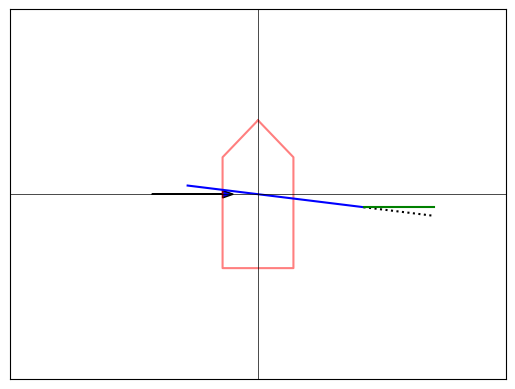

In [57]:
# Experimental inputs
apparent_wind_speed = 10  # m/s

wind_direction = -90  # degrees, follows WindSensor.msg convention

boat_direction = 0  # degrees, always zero. Boat's bow points in +y direction

look_up_table = np.array(
    [[50000, 5.75], [100000, 6.75], [200000, 7], [500000, 9.75], [1000000, 10]]
)  # [reynolds number, angle of attack(degrees)]

# Determine trimtab angle
reynolds = compute_reynolds_number(apparent_wind_speed)
a = compute_angle_of_attack(reynolds, look_up_table)
t = compute_trim_tab_angle(a, wind_direction, 0)

#
print("Wind direction: ", wind_direction)
print("Reynolds number: ", reynolds)
print("Angle of attack: ", a)
print("Trim tab angle: ", t)

# Construct wingsail, turn wingsail to be with the wind, rotate trim tab, rotate main sail to alpha
wingsail = [[0, 2], [0, 0], [0, -3], [0, -5], [0, -3], [0, -5]]
wingsail = rotate_object_around_origin(wingsail, -wind_direction)
wingsail = rotate_trimtab(wingsail, t)
wingsail = rotate_object_around_origin(wingsail, -t)

# Drawing commands
drawWind(wind_direction)
drawBoat()
drawSail(wingsail)
drawPlot()
